--- Starting simulation of word cat	... Time for simulation: 0.241187 seconds
--- Starting simulation of word dog	... Time for simulation: 0.253156 seconds
--- Starting simulation of word abrupt	... Time for simulation: 0.269662 seconds
--- Starting simulation of word territory	... Time for simulation: 0.258804 seconds
--- Starting simulation of word abandon	... Time for simulation: 0.304343 seconds
--- Starting simulation of word clamp	... Time for simulation: 0.252167 seconds
--- Starting simulation of word intolerable	... Time for simulation: 0.254806 seconds
--- Starting simulation of word sew	... Time for simulation: 0.243537 seconds


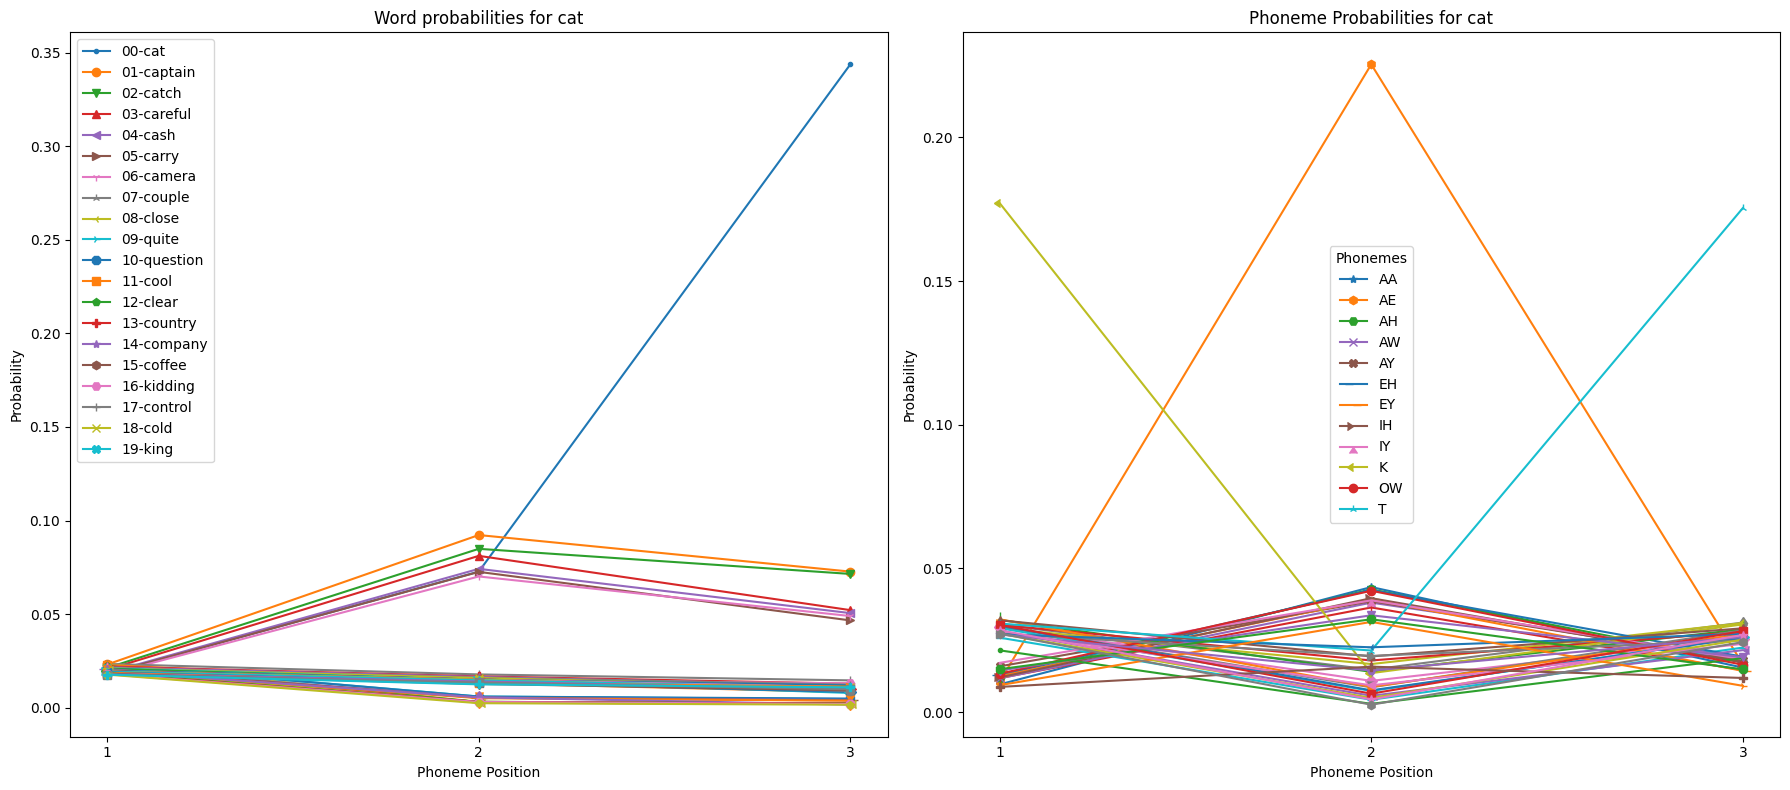

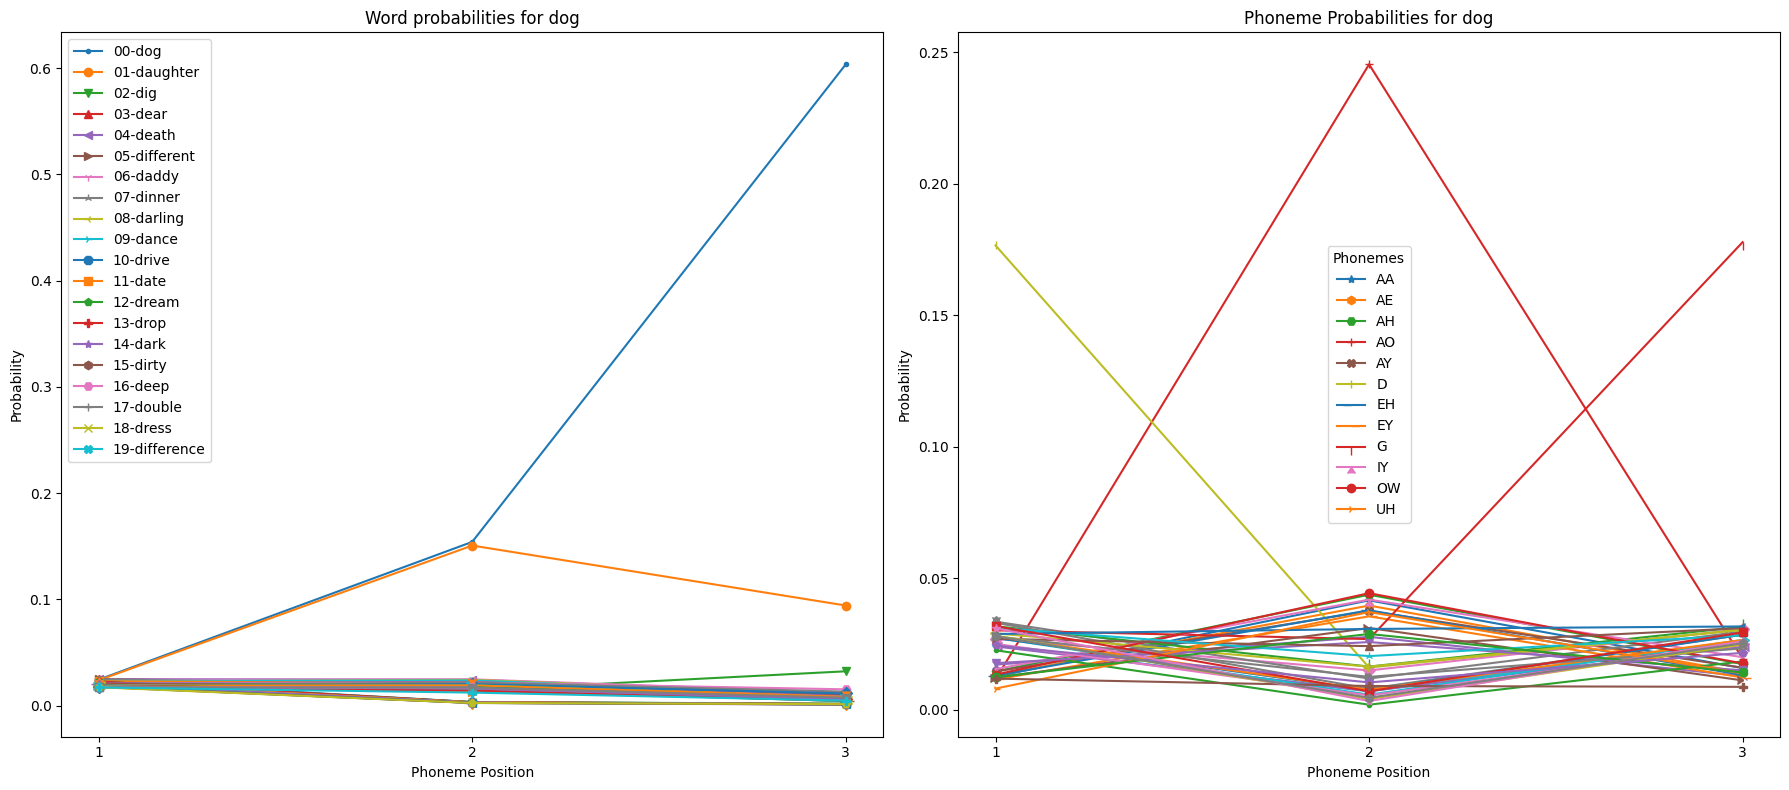

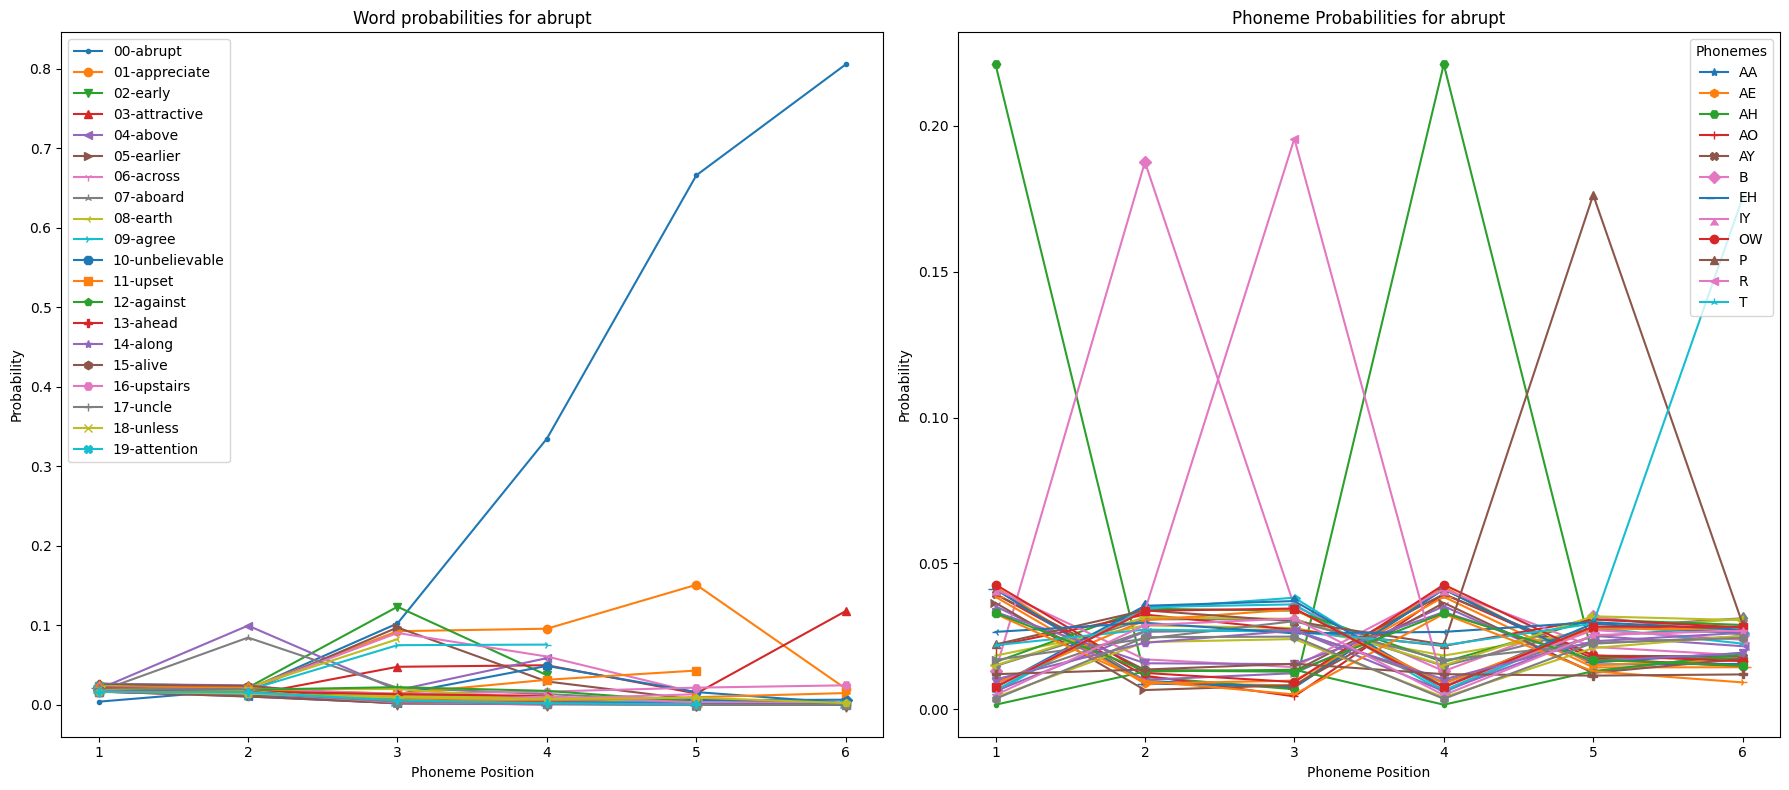

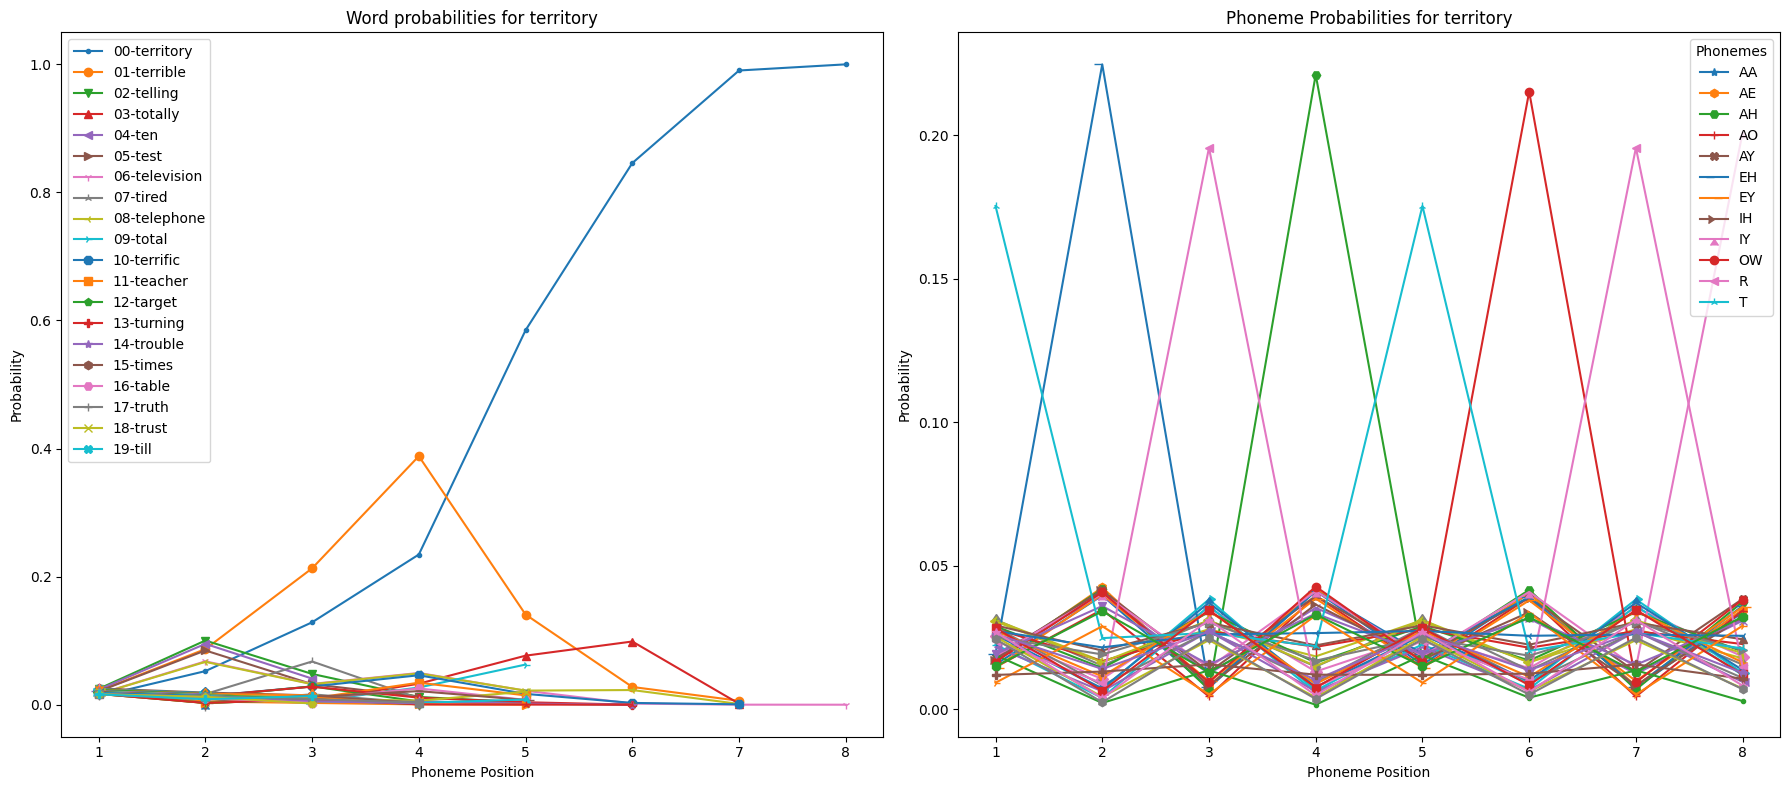

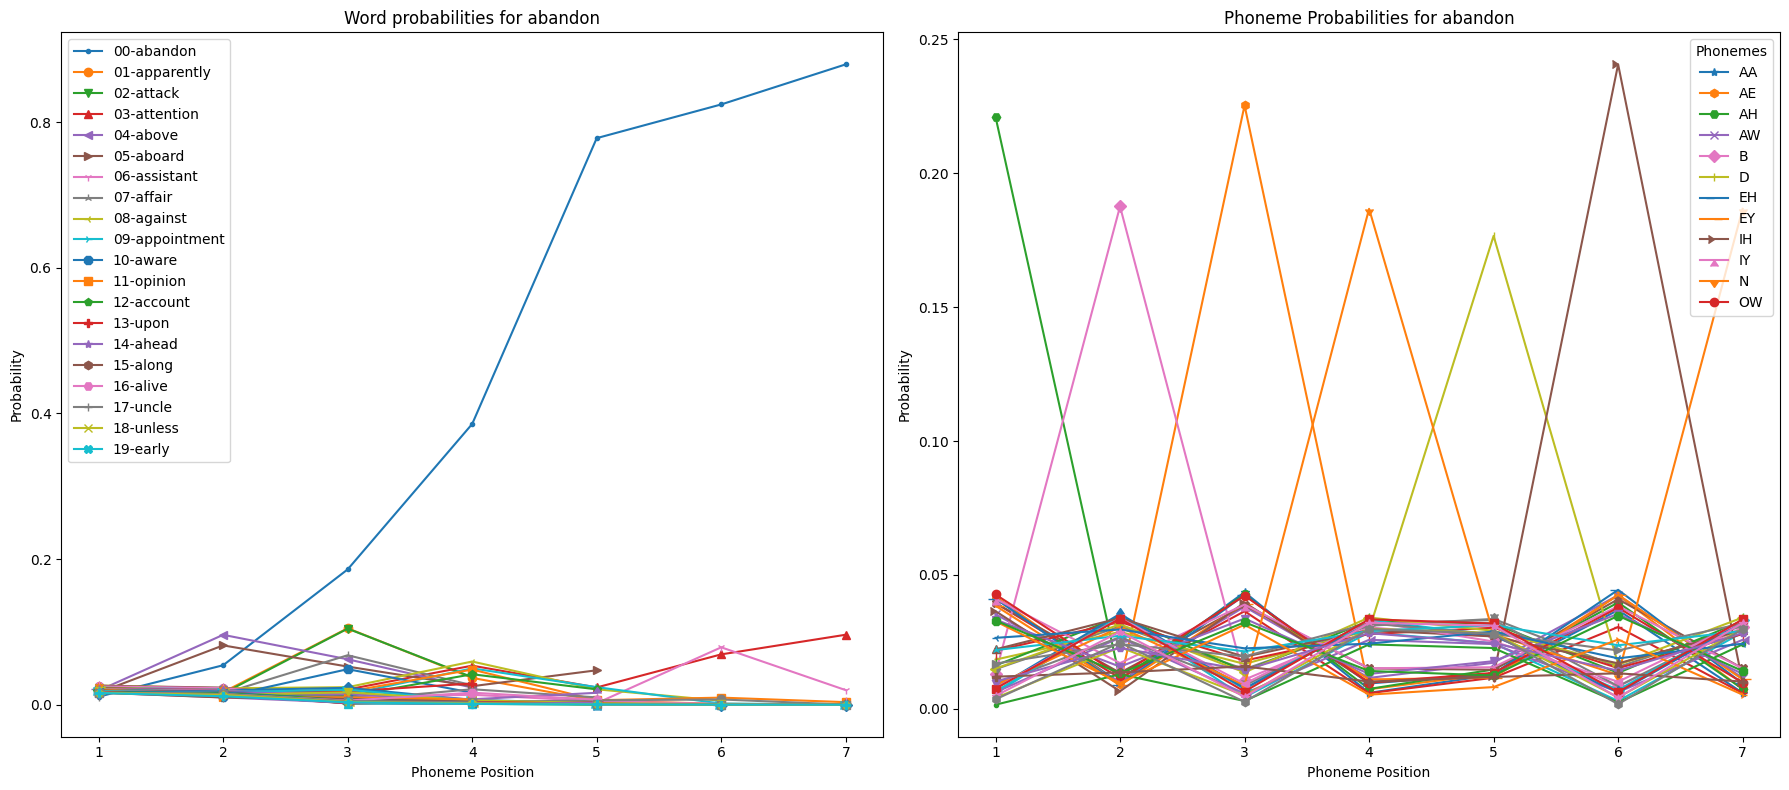

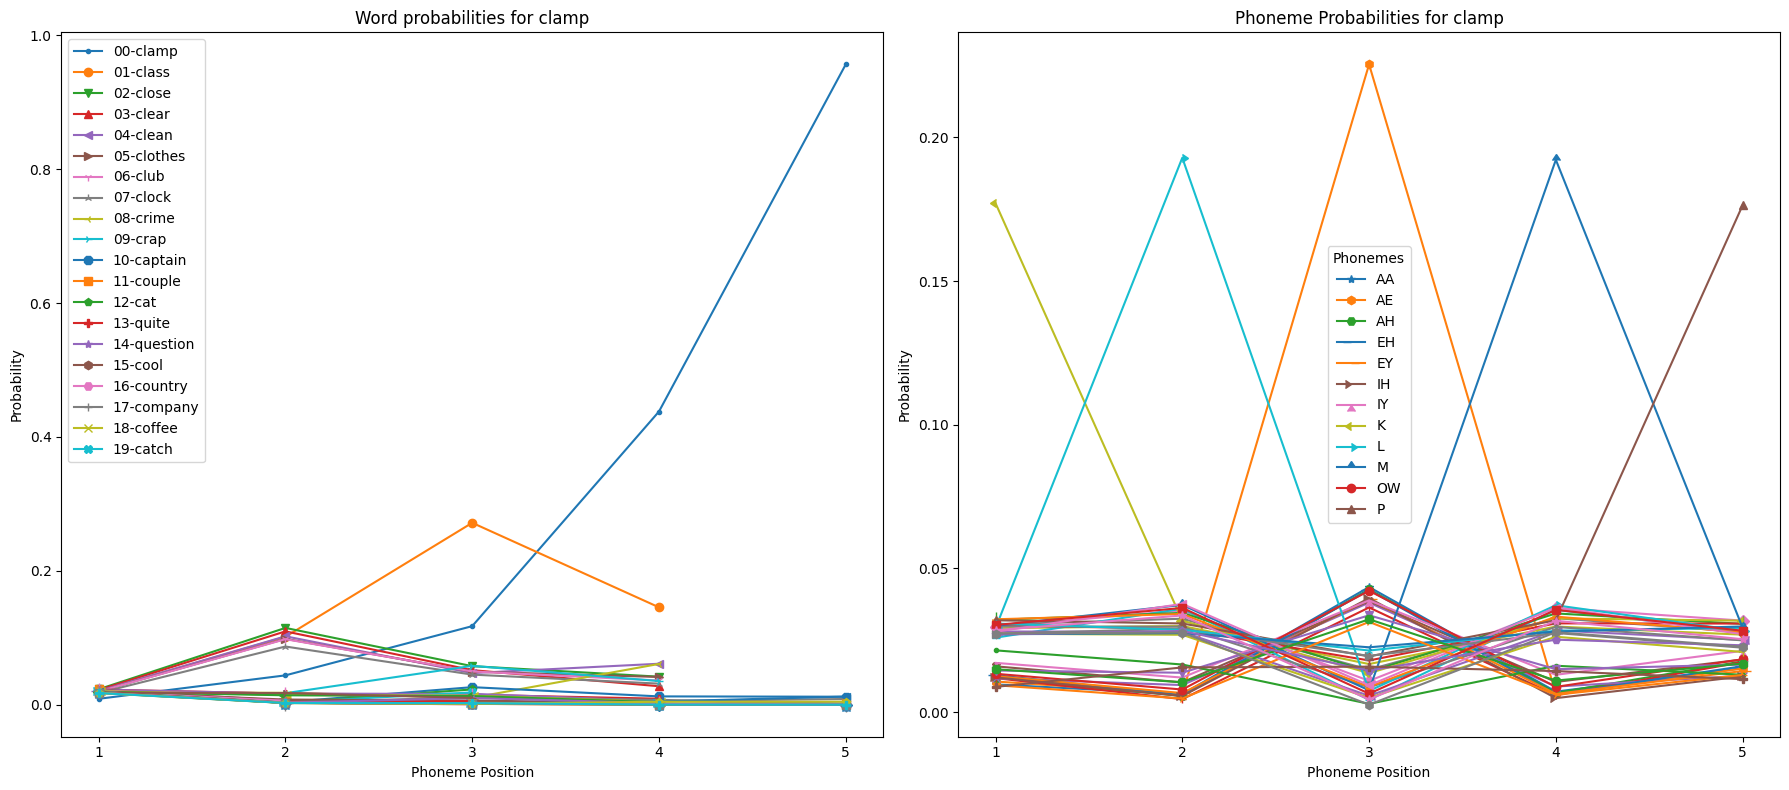

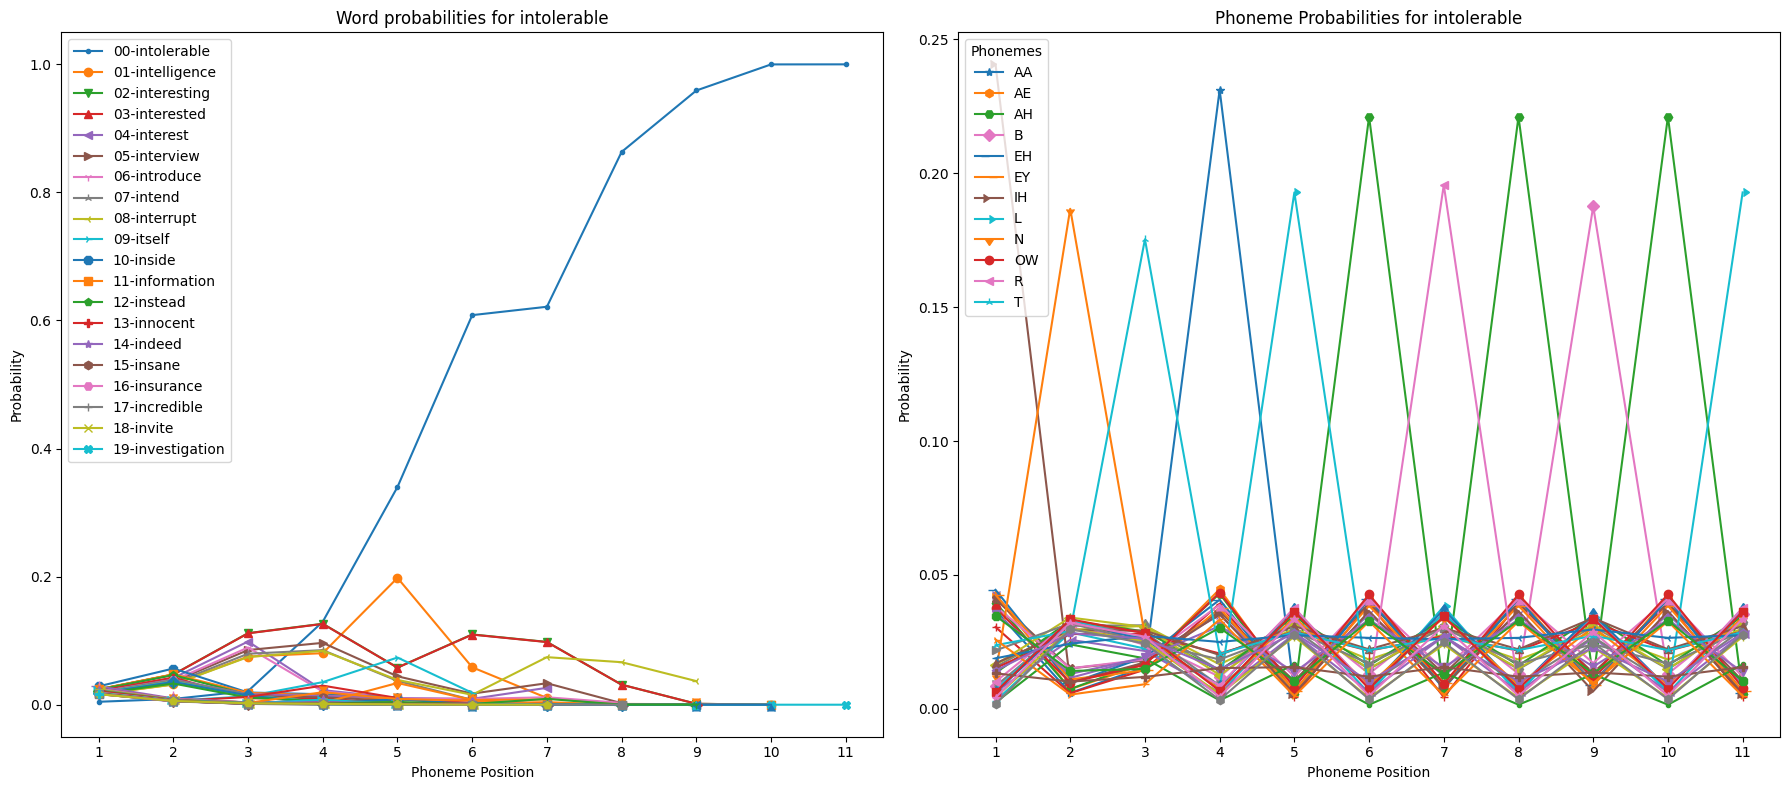

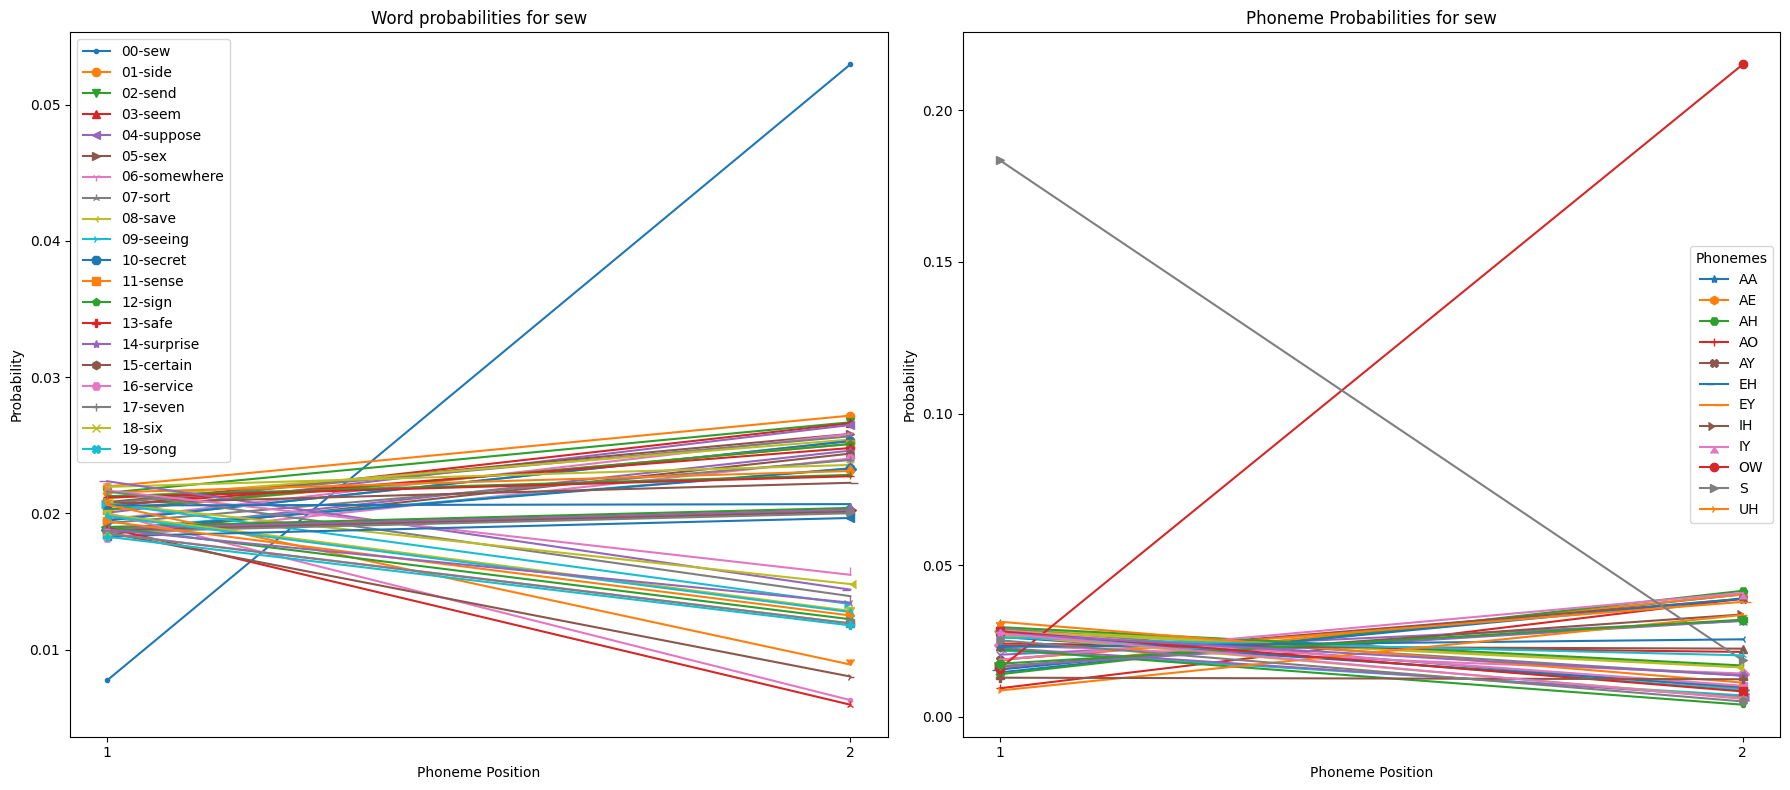

In [8]:

import time
from collections import defaultdict
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
import seaborn as sns

def get_phoneme_prob_at_position(phoneme, normalized_cosine_sim_df, phoneme_prob_dict):
    
    """
    Calculate the bottom-up probability for a phoneme at a given position.
    
    Parameters:
        phoneme (str): The current phoneme.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing the normalized cosine similarities between phonemes.
        phoneme_prob_dict (dict): The dictionary containing the probabilities of each phoneme.
        
    Returns:
        pd.Series: The probabilities of each phoneme at the current position.
    """
    evidence_distribution = normalized_cosine_sim_df.loc[phoneme]
    
    # Instead of multiplying the whole Series with a dictionary, use map for element-wise multiplication
    evidence_distribution = evidence_distribution.map(lambda x: x * phoneme_prob_dict.get(x, 1))

    # normalize (back to probabilities) and return
    return evidence_distribution / evidence_distribution.sum()

def sim_bayes_new(target_word, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX=50):
    """
    Simulate word recognition based on Bayesian inference.
    
    Parameters:
        target_word (str): The target word to recognize.
        lexicon_df (DataFrame): The DataFrame containing the lexicon.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing the normalized cosine similarities between phonemes.
        phoneme_prob_dict (dict): The dictionary containing the probabilities of each phoneme.
        topX: how many words to retain in the dictionary based on peak evidence values
        
    Returns:
        posterior_word_df, posterior_phon_df: 2 dataframes with word and phoneme probabilities by position
    """
    # Initialize
    start_time = time.time()
    print(f'--- Starting simulation of word {target_word}', end = "")
    # let's get the phonemes for the target word
    # this just pulls the Pronunciation for the target word
    target_pronunciation = lexicon_df.loc[lexicon_df['Item'] == target_word, 'Pronunciation'].values[0]
    target_phonemes = target_pronunciation.split()
    result_list = []
    phoneme_prob_list = []  # New list to store phoneme probabilities

    # Print the elapsed time -- nothing essential, just updating the user
    # part1 = time.time()
    # elapsed_time = part1 - start_time
    # print(f"  Part 1a: {elapsed_time:.6f} seconds")
    
    # this is wasteful to compute every time, but it takes very little time
    # we need the sum of all lfrq values to convert to probabilities
    total_frequency = lexicon_df['lfrq'].sum()
    
    # now we divide the lfrq values by total_frequency
    # we go ahead and do it in word_prob_dict because it has local scope -- we 
    # are not changing the lexicon outside the function, just the 'copy' we have
    # inside the function (could make a version of this outside the function and
    # pass it inside and then skip this normalization step...)
    word_prob_dict = {row['Item']: row['lfrq'] / total_frequency for index, row in lexicon_df.iterrows()}

    # Print the elapsed time -- just keeping user updated, and trying to figure
    # out how long each part is taking
    # part2 = time.time()
    # elapsed_time = part2 - part1
    # print(f"  Part 1b: {elapsed_time:.6f} seconds")

    # Print the elapsed time from start_time so far
    # elapsed_time = time.time() - start_time
    # print(f"  Times so far: {elapsed_time:.6f} seconds")

    # Loop through each phoneme in the target word
    for phoneme_pos, phoneme in enumerate(target_phonemes, 1):
        phon_start = time.time()

        # Step 1: Get the bottom-up probability for the phoneme
        phoneme_prob_at_pos = get_phoneme_prob_at_position(phoneme, normalized_cosine_sim_df, phoneme_prob_dict)
        
        # Store the phoneme probabilities in the new list
        for p, prob in phoneme_prob_at_pos.items():
            phoneme_prob_list.append({'Phoneme Position': phoneme_pos, 'Phoneme': p, 'Probability': prob})
            # for debugging / inspection -- uncomment next line to see the phoneme probabilities at 
            # each phoneme_pos
            #print(f'     ##### Phoneme Position {phoneme_pos}, Phoneme {p}, Probability {prob}')

        # Step 2: Calculate the probability of each word's substrings (pseq)
        updated_prob_dict = defaultdict(float)
        for word, word_pronunciation in lexicon_df[['Item', 'Pronunciation']].values:
            word_phonemes = word_pronunciation.split()
            
            # this is brute force way to deal with words that are shorter than 
            # the current word -- we just ignore them once the input is longer 
            # than their length... Maybe this is not the best idea? To look at
            # later... 
            if len(word_phonemes) < phoneme_pos:
                continue
            
            # now we want pseq to be the product of the phoneme probabilities 
            # for the current word at each position. We set it to 1.0 initially
            # so we can multiply it by the probabilities... This is the likelihood
            # step: 𝐿𝑖𝑘𝑒𝑙𝑖ℎ𝑜𝑜𝑑(𝑊𝑜𝑟𝑑𝑖)=𝑃(𝐸𝑣𝑖𝑑𝑒𝑛𝑐𝑒|𝑊𝑜𝑟𝑑𝑖)=𝑃(𝑃ℎ𝑜𝑛𝑒𝑚𝑒𝑆𝑡𝑟𝑖𝑛𝑔𝑖)=∏𝑗=1𝑙𝑃(𝑃ℎ𝑜𝑛𝑒𝑚𝑒𝑗|𝐸𝑣𝑖𝑑𝑒𝑛𝑐𝑒)
            pseq = 1.0
            for i in range(phoneme_pos):
                pseq *= phoneme_prob_at_pos.get(word_phonemes[i], 0)
                
            # Step 3: Multiply by word probability and update
            # We take the pseq product and multiply by the word's probability
            # this is the step of 𝑃(𝐸𝑣𝑖𝑑𝑒𝑛𝑐𝑒|𝑊𝑜𝑟𝑑𝑖)×𝑃(𝑊𝑜𝑟𝑑𝑖) for 𝑊𝑜𝑟𝑑𝑖
            updated_prob_dict[word] = pseq * word_prob_dict[word]
        
        # Diagnostic prints for phoneme position 1
        # if phoneme_pos == 1:
        prob_values = list(updated_prob_dict.values())
        # print(f"Statistics before normalization at phoneme {phoneme_pos}:")
        # print(f"  Max: {max(prob_values):.15f}")
        # print(f"  Min: {min(prob_values):.15f}")
        # print(f"  Mean: {sum(prob_values) / len(prob_values):.15f}")
        # print(f"  Std: {sum((x - sum(prob_values) / len(prob_values))**2 for x in prob_values)**0.5 / len(prob_values):.15f}")

        # Sort by probability and take only top X words
        sorted_words = sorted(updated_prob_dict.items(), key=lambda x: x[1], reverse=True)[:topX]
        # Always include the target_word
        if target_word not in [word for word, _ in sorted_words]:
            sorted_words.append((target_word, updated_prob_dict.get(target_word, 0)))

        total_prob = sum([prob for word, prob in sorted_words])
        
        # Normalize only top X words
        updated_prob_dict = {word: prob / total_prob for word, prob in sorted_words}

        # Update lexicon to only include these top X words for the next phoneme
        lexicon_df = lexicon_df[lexicon_df['Item'].isin([word for word, prob in sorted_words])]
        
        # Normalize the updated probabilities
        total_prob = sum(updated_prob_dict.values())
        for word in updated_prob_dict:
            updated_prob_dict[word] /= total_prob
        
        # Diagnostic prints for phoneme position 1
        # if phoneme_pos == 1:
        # prob_values = list(updated_prob_dict.values())
        # print(f"Statistics POST normalization at phoneme {phoneme_pos}:")
        # print(f"  Max: {max(prob_values):.15f}")
        # print(f"  Min: {min(prob_values):.15f}")
        # print(f"  Mean: {sum(prob_values) / len(prob_values):.15f}")
        # print(f"  Std: {sum((x - sum(prob_values) / len(prob_values))**2 for x in prob_values)**0.5 / len(prob_values):.15f}")

        # Update word_prob_dict for next iteration
        word_prob_dict = updated_prob_dict
        
        # Create a DataFrame for this phoneme position and append to the result list
        temp_df = pd.DataFrame(list(word_prob_dict.items()), columns=['Item', 'Probability'])
        temp_df = temp_df.sort_values(by='Probability', ascending=False)
        temp_df['Phoneme Position'] = phoneme_pos
        result_list.append(temp_df)
        
        # Print the elapsed time for this phoneme
        # elapsed_time = time.time() - phon_start
        # print(f"      Time elapsed after processing phoneme {phoneme_pos}: {elapsed_time:.6f} seconds")        
        
    # New DataFrame for phoneme probabilities
    posterior_phon_df = pd.DataFrame(phoneme_prob_list)
    
    # Combine all the DataFrames into one and return 
    # [ignore_index=True speeds things by disregarding existing index values]
    result_df = pd.concat(result_list, ignore_index=True)

    # Calculate peak activations for each word
    peak_activations = result_df.groupby('Item')['Probability'].max().sort_values(ascending=False).reset_index()
    
    # Select the target topX words by peak activation
    top_words = peak_activations.head(topX)
    
    # Filter final results to only include these top words
    posterior_word_df = result_df[result_df['Item'].isin(top_words['Item'])]
    
    # Create an ordered list of words based on peak activations
    sorted_words_by_peak = top_words['Item'].tolist()

    # Move the target word to the top of the list
    sorted_words_by_peak.remove(target_word)
    sorted_words_by_peak = [target_word] + sorted_words_by_peak
    
    # Create a dictionary to map each word to its index in sorted_words_by_peak, formatted as a string
    sort_order = {word: f"{index:02d}" for index, word in enumerate(sorted_words_by_peak)}
    
    # Add a new column that indicates the sort order based on peak activations
    posterior_word_df = posterior_word_df.copy()
    posterior_word_df['ItemWithOrder'] = posterior_word_df['Item'].apply(lambda x: f"{sort_order.get(x, '99')}-{x}")
    
    # Add a target_word column to the final result DataFrames; could help with subsequent analysis
    posterior_word_df['Target Word'] = target_word
    posterior_phon_df['Target Word'] = target_word
     
    # Print the total elapsed time
    total_elapsed_time = time.time() - start_time
    print(f"\t... Time for simulation: {total_elapsed_time:.6f} seconds")
    
    return posterior_word_df, posterior_phon_df  # Return both DataFrames


def plot_simulation_result(word_result, phon_result, log_scale=False, full_scale=False,
                           saveplots=False, phonplot=12, wordplot=20):
    """
    Plots a line graph based on the simulation result DataFrame and phoneme probabilities.
    
    Parameters:
        word_result (DataFrame): The DataFrame containing simulation results.
        phon_result (DataFrame): The DataFrame containing phoneme probabilities.
        log_scale (bool): Whether to use a log scale for the Y-axis. Default is False.
    """
    
    unique_words = word_result['Target Word'].unique()
    
    for word in unique_words:
        # Filter data for the current word
        word_data = word_result[word_result['Target Word'] == word]
        phon_data = phon_result[phon_result['Target Word'] == word]
        
        marker_list = [".","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
        marker_iter = itertools.cycle(marker_list)
        
        fig, axs = plt.subplots(1, 2, figsize=(18, 8))
        
        # Initialize empty lists for legend labels and handles
        word_legend_labels = []
        word_legend_handles = []
        
        # First subplot for word probabilities
        for name, group in word_data.groupby('ItemWithOrder'):
            marker = next(marker_iter)
            line, = axs[0].plot(group['Phoneme Position'], group['Probability'], marker=marker, markersize=6)
            word_legend_labels.append(name)
            word_legend_handles.append(line)
        
        # the wordplot arguments limit the lists to that many items in the legend, even if more lines plot
        axs[0].legend(word_legend_handles[:wordplot], word_legend_labels[:wordplot])
        axs[0].set_xlabel('Phoneme Position')
        axs[0].set_ylabel('Probability')
        axs[0].set_title(f'Word probabilities for {word}')
        axs[0].set_xticks(np.arange(min(word_data['Phoneme Position']), max(word_data['Phoneme Position']) + 1, 1.0))
        
        # Calculate peak activations for each phoneme
        peak_phoneme_activations = phon_data.groupby('Phoneme')['Probability'].max().sort_values(ascending=False).reset_index()
        
        # Select the topphon phonemes by peak activation
        top_phonemes = peak_phoneme_activations.head(phonplot)['Phoneme'].tolist()
        #print(top_phonemes)
        
        # Initialize empty lists for legend labels and handles
        phoneme_legend_labels = []
        phoneme_legend_handles = []
        
        # Second subplot for phoneme probabilities
        for name, group in phon_data.groupby('Phoneme'):
            marker = next(marker_iter)
            line, = axs[1].plot(group['Phoneme Position'], group['Probability'], marker=marker, markersize=6)
            # Only add to the legend if the phoneme is among the topphon
            if name in top_phonemes:
                phoneme_legend_labels.append(name)
                phoneme_legend_handles.append(line)        
                
        axs[1].legend(phoneme_legend_handles[:phonplot], phoneme_legend_labels[:phonplot], title='Phonemes')
        axs[1].set_xlabel('Phoneme Position')
        axs[1].set_ylabel('Probability')
        axs[1].set_title(f'Phoneme Probabilities for {word}')
        axs[1].set_xticks(np.arange(min(phon_data['Phoneme Position']), max(phon_data['Phoneme Position']) + 1, 1.0))
        
        if log_scale:
            axs[0].set_yscale('log')
            axs[1].set_yscale('log')
        
        plt.tight_layout()
        #full_scale = True
        # If full_scale is True, set the y-axis to range from 0 to 1
        if full_scale:
            axs[0].set_ylim([0, 1])
            axs[1].set_ylim([0, 1])
        
        if saveplots:
            # Ensure the directory exists
            if not os.path.exists('plots'):
                os.makedirs('plots')
            plt.savefig(f'plots/{word}.png')
        
        plt.show()


def run_simulations(word_list, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX=50):
    """
    Runs simulations for a list of words and returns aggregated results.
    
    Parameters:
        word_list (list): List of words to simulate.
        lexicon_df (DataFrame): The DataFrame containing the lexicon.
        normalized_cosine_sim_df (DataFrame): The DataFrame containing normalized cosine similarities.
        phoneme_prob_dict (dict): Dictionary containing the probabilities of each phoneme.
        topX (int): Number of top words to consider during simulation. Default is 50.
    
    Returns:
        DataFrame, DataFrame: Aggregated word and phoneme results.
    """
    
    # Initialize empty DataFrames to store aggregated results
    aggregated_word_results = pd.DataFrame()
    aggregated_phoneme_results = pd.DataFrame()
    
    for word in word_list:
        #print(f"--- Running simulation for word: {word}")
        word_result, phon_result = sim_bayes_new(word, lexicon_df, normalized_cosine_sim_df, phoneme_prob_dict, topX)
        
        # Append the results to the aggregated DataFrames
        aggregated_word_results = pd.concat([aggregated_word_results, word_result], ignore_index=True)
        aggregated_phoneme_results = pd.concat([aggregated_phoneme_results, phon_result], ignore_index=True)
    
    return aggregated_word_results, aggregated_phoneme_results


# Function to read in the lexicon file
def read_lexicon_file(filepath):
    lexicon_df = pd.read_csv(filepath)
    return lexicon_df

# Read the lexicon file
lexicon_df = read_lexicon_file('./lemmalex.csv')

# Drop any rows with NaN [not a number, here indicating no value] available
# values in the 'Pronunciation' column
lexicon_df = lexicon_df.dropna(subset=['Pronunciation'])

# add log frequency column
lexicon_df['lfrq'] = np.log(lexicon_df['Frequency'] + 1)
# lexicon_df.head()

# Calculate mean and standard deviation of 'lfrq'
mean_lfrq = lexicon_df['lfrq'].mean()
std_lfrq = lexicon_df['lfrq'].std()

# Define the boundaries for acceptable 'lfrq' values
lower_bound = mean_lfrq - 3 * std_lfrq
upper_bound = mean_lfrq + 3 * std_lfrq

# Remove records where 'lfrq' is more than 3 standard deviations from the mean
filtered_lexicon_df = lexicon_df[(lexicon_df['lfrq'] >= lower_bound) & (lexicon_df['lfrq'] <= upper_bound)]
# let's just replace lexicon_df with the filtered one
lexicon_df = filtered_lexicon_df


# Extract unique phonemes
unique_phonemes = set()
for pronunciation in lexicon_df['Pronunciation']:
    phonemes = pronunciation.split()
    unique_phonemes.update(phonemes)
sorted_unique_phonemes = sorted(list(unique_phonemes))
num_phonemes = len(sorted_unique_phonemes)
phoneme_to_index = {phoneme: index for index, phoneme in enumerate(sorted_unique_phonemes)}

# Create a weighted matrix for phoneme pairs
weighted_phoneme_matrix_dict = defaultdict(float)
# create dictionary for frequency-weighted counts of each phoneme
phoneme_count_dict = defaultdict(float)


# Now let's fill the matrix
fweight = 1.0 # how much to use frequency; when set to 1, just use full value
for _, row in lexicon_df.iterrows():
    pronunciation, lfrq = row['Pronunciation'], row['lfrq']
    phonemes = pronunciation.split()
    
    # Update the frequency-weighted count for each individual phoneme
    for phoneme in phonemes:
        phoneme_count_dict[phoneme] += (lfrq * fweight)
 
    for i in range(len(phonemes) - 1):
        first_phoneme, second_phoneme = phonemes[i], phonemes[i + 1]
        weighted_phoneme_matrix_dict[(first_phoneme, second_phoneme)] += (lfrq * fweight)
        weighted_phoneme_matrix_dict[(second_phoneme, first_phoneme)] += (lfrq * fweight)


# Initialize the weighted matrix
weighted_phoneme_matrix = np.zeros((num_phonemes, num_phonemes), dtype=float)
for (first, second), count in weighted_phoneme_matrix_dict.items():
    i, j = phoneme_to_index[first], phoneme_to_index[second]
    weighted_phoneme_matrix[i, j] = count

# Convert the matrix to a DataFrame for better readability
weighted_phoneme_matrix_df = pd.DataFrame(weighted_phoneme_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Convert the phoneme_count_dict to a DataFrame for better readability
phoneme_count_df = pd.DataFrame(list(phoneme_count_dict.items()), columns=['Phoneme', 'FrequencyWeightedCount']).sort_values(by='FrequencyWeightedCount', ascending=False)

# Calculate the sum of all FrequencyWeightedCount values
total_count = phoneme_count_df['FrequencyWeightedCount'].sum()

# Add a new column for normalized probabilities
phoneme_count_df['phon_prob'] = phoneme_count_df['FrequencyWeightedCount'] / total_count

# Create a simpler dictionary that just pairs phonemes with their normalized probabilities (phon_prob)
phoneme_prob_dict = dict(zip(phoneme_count_df['Phoneme'], phoneme_count_df['phon_prob']))
phoneme_prob_dict

# Display a portion of the weighted matrix and phoneme count matrix for review
weighted_phoneme_matrix_df.iloc[:10, :5], phoneme_prob_dict#,phoneme_count_df.iloc[:100, :10]

from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity between each pair of phoneme vectors
cosine_sim_matrix = cosine_similarity(weighted_phoneme_matrix)

# Convert the similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the cosine similarity matrix
cosine_sim_df.iloc[:10, :10]
# Reduce the off-diagonal entries -- divide by 5 for now
off_diagonal_indices = np.where(~np.eye(cosine_sim_matrix.shape[0], dtype=bool))
adjusted_cosine_sim_matrix = cosine_sim_matrix.copy()
adjusted_cosine_sim_matrix[off_diagonal_indices] /= 5.0

# Convert the adjusted similarity matrix to a DataFrame for better readability
adjusted_cosine_sim_df = pd.DataFrame(adjusted_cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the adjusted cosine similarity matrix
adjusted_cosine_sim_df.iloc[:10, :10]



# Normalize the rows of the adjusted cosine similarity matrix so they sum to 1
row_sums = adjusted_cosine_sim_matrix.sum(axis=1)
normalized_cosine_sim_matrix = adjusted_cosine_sim_matrix / row_sums[:, np.newaxis]

# Convert the normalized similarity matrix to a DataFrame for better readability
normalized_cosine_sim_df = pd.DataFrame(normalized_cosine_sim_matrix, index=sorted_unique_phonemes, columns=sorted_unique_phonemes)

# Display a portion of the normalized cosine similarity matrix
normalized_cosine_sim_df.iloc[:10, :10]








# Example usage:
word_list = ['cat', 'dog', 'abrupt', 'territory', 'abandon', 'clamp', 'intolerable', 'sew']
aggregated_word_results, aggregated_phoneme_results = run_simulations(word_list, lexicon_df, 
                                                                      normalized_cosine_sim_df, phoneme_prob_dict)
plot_simulation_result(aggregated_word_results, aggregated_phoneme_results)